In [2]:
import init_notebooks
from data.load_data import load_data 
from models.train_model import split_data
from models.evaluation import accuracy , heat_cm 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

In [3]:
df_train = load_data('processed_train')
df_test = load_data('processed_test')

In [4]:
X_train = df_train.drop("TN3", axis=1)
y_train = df_train["TN3"]

X_test = df_test.drop("TN3", axis=1)
y_test = df_test["TN3"]

In [ ]:
import joblib 

num_cols_train = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols_train = X_train.select_dtypes(include=['object', 'category']).columns.tolist()


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols_train),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_train)
])
X_train_processed = preprocessor.fit_transform(X_train)


joblib.dump(preprocessor, "../models/preprocessor.pkl")

['../models/preprocessor.pkl']

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import joblib



y_train_bin = y_train.map({'NON OBSERVEE': 0, 'OBSERVEE': 1})


pipeline = ImbPipeline([
    ('preprocessor', preprocessor), 
    ('smote', SMOTE(random_state=42)), 
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])


param_dist = {
    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__max_features': ['sqrt', 'log2', None],
}


rfc_optimized = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,          
    scoring='f1',        
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rfc_optimized.fit(X_train, y_train_bin)

print("Meilleurs paramètres :", rfc_optimized.best_params_)
print("Meilleur F1 :", rfc_optimized.best_score_)


joblib.dump(rfc_optimized.best_estimator_, "../models/random_forest_optimized_SMOTE.pkl")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_split=10, clf__n_estimators=200; total time= 1.1min
[CV] END clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_split=10, clf__n_estimators=200; total time= 1.1min
[CV] END clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_split=10, clf__n_estimators=200; total time= 1.2min
[CV] END clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_split=10, clf__n_estimators=200; total time= 1.2min
[CV] END clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_split=10, clf__n_estimators=200; total time= 1.2min
[CV] END clf__max_depth=None, clf__max_features=log2, clf__min_samples_split=5, clf__n_estimators=500; total time= 2.8min
[CV] END clf__max_depth=None, clf__max_features=log2, clf__min_samples_split=5, clf__n_estimators=500; total time= 2.8min
[CV] END clf__max_depth=None, clf__max_features=log2, clf__min_samples_split=5, clf__n_es

['../models/random_forest_optimized_SMOTE.pkl']

In [ ]:
best_rfc = rfc_optimized.best_estimator_


=== RÉSULTATS CLASSE NON OBSERVEE ===
Accuracy  : 0.981
Precision : 0.827
Recall    : 0.789
F1-Score  : 0.808
PR-AUC' : 0.827

=== Rapport détaillé ===
              precision    recall  f1-score   support

NON OBSERVEE       0.83      0.79      0.81       498
    OBSERVEE       0.99      0.99      0.99      9363

    accuracy                           0.98      9861
   macro avg       0.91      0.89      0.90      9861
weighted avg       0.98      0.98      0.98      9861



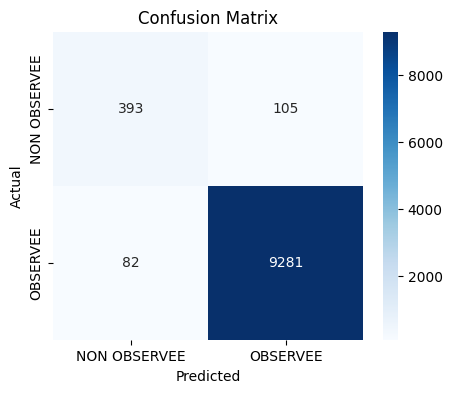

In [ ]:
import joblib
from sklearn.metrics import auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

rfc_optimized = joblib.load("../models/random_forest_optimized_SMOTE.pkl")

X_test_processed = X_test 

y_test_bin = y_test.map({'NON OBSERVEE': 0, 'OBSERVEE': 1})


y_pred_bin = rfc_optimized.predict(X_test_processed)

y_prob_non_observee = rfc_optimized.predict_proba(X_test_processed)[:, 0] 

precision, recall, thresholds = precision_recall_curve(y_test_bin, y_prob_non_observee, pos_label=0)

accuracy_opt = accuracy_score(y_test_bin, y_pred_bin)
precision_opt = precision_score(y_test_bin, y_pred_bin, pos_label=0)
recall_opt = recall_score(y_test_bin, y_pred_bin, pos_label=0)
f1_opt = f1_score(y_test_bin, y_pred_bin, pos_label=0)
pr_auc = auc(recall, precision)

print("\n=== RÉSULTATS CLASSE NON OBSERVEE ===")
print(f"Accuracy  : {accuracy_opt:.3f}")
print(f"Precision : {precision_opt:.3f}")
print(f"Recall    : {recall_opt:.3f}")
print(f"F1-Score  : {f1_opt:.3f}")
print(f"PR-AUC' : {pr_auc:.3f}")

print("\n=== Rapport détaillé ===")
print(classification_report(y_test_bin, y_pred_bin, target_names=['NON OBSERVEE', 'OBSERVEE']))


cm = confusion_matrix(y_test_bin, y_pred_bin)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NON OBSERVEE','OBSERVEE'], yticklabels=['NON OBSERVEE','OBSERVEE'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [5]:
importances = rfc_optimized.named_steps['clf'].feature_importances_
features = df_train.columns
for feat, imp in sorted(zip(features, importances), key=lambda x: x[1], 	reverse=True):
		print(f"{feat}: {imp:.4f}")

Numero_grappe: 0.1719
lat: 0.1357
niveau_education_max: 0.1065
Poids_menage: 0.0944
Numero_menage: 0.0879
Age: 0.0771
Presence_parents: 0.0760
Score_richesse_menage: 0.0719
Region: 0.0447
Milieu_urbain_rural: 0.0360
Niveau_edu_pere: 0.0341
Quintile_richesse_menage: 0.0269
Niveau_edu_mere: 0.0133
TN3: 0.0108
Niveau_edu_chef: 0.0096
lon: 0.0011
enfants: 0.0011
ratio_enfants_adultes: 0.0009
adultes: 0.0000
taille_menage: 0.0000


In [ ]:
import pandas as pd
import joblib


model = joblib.load("../models/random_forest_optimized_SMOTE.pkl")


if hasattr(model, 'named_steps'):
    rfc_optimized = model.named_steps['clf']
else:
    rfc_optimized = model

feature_importance_opt = pd.DataFrame({
    'feature': X_train.columns,  
    'importance': rfc_optimized.feature_importances_
}).sort_values('importance', ascending=False)


threshold = 0.01
selected_features = feature_importance_opt[
    feature_importance_opt['importance'] > threshold
]['feature'].tolist()

print(f"\nNombre de features initial : {len(X_train.columns)}")
print(f"Nombre de features sélectionnées (>{threshold*100}%) : {len(selected_features)}")
print(f"Features éliminées : {len(X_train.columns) - len(selected_features)}")

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]



Nombre de features initial : 20
Nombre de features sélectionnées (>1.0%) : 14
Features éliminées : 6


In [ ]:
"""# Extraction des importances
importances = rfc_optimized.feature_importances_
features = X_train_selected.columns
for feat, imp in sorted(zip(features, importances), key=lambda x: x[1],reverse=True):
    print(f"{feat}: {imp:.4f}")"""

'# Extraction des importances\nimportances = rfc_optimized.feature_importances_\nfeatures = X_train_selected.columns\nfor feat, imp in sorted(zip(features, importances), key=lambda x: x[1],reverse=True):\n    print(f"{feat}: {imp:.4f}")'

In [6]:
import joblib

# Charger le pipeline
pipeline = joblib.load("../models/random_forest_optimized_SMOTE.pkl")

# Le modèle optimisé est dans le dernier step du pipeline
rfc_optimized = pipeline.named_steps["clf"]     # ou le nom que tu as donné au step

# Récupérer ses hyperparamètres réels
best_params = rfc_optimized.get_params()


In [ ]:
import joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


def convert_pred(pred):
    if isinstance(pred[0], str):
        return pred  
    mapping = {0: "NON OBSERVEE", 1: "OBSERVEE"}
    return np.array([mapping[p] for p in pred])

pipeline = joblib.load("../models/random_forest_optimized_SMOTE.pkl")
rfc_optimized = pipeline.named_steps["clf"]

pos = "NON OBSERVEE"


pred_opt_raw = rfc_optimized.predict(X_test)
y_val_pred_opt = convert_pred(pred_opt_raw)
f1_opt = f1_score(y_test, y_val_pred_opt, pos_label=pos)


best_params = rfc_optimized.get_params()
best_params.pop("random_state", None)


rfc_selected = RandomForestClassifier(**best_params, random_state=42)
rfc_selected.fit(X_train_selected, y_train)

pred_sel_raw = rfc_selected.predict(X_test_selected)
y_val_pred_selected = convert_pred(pred_sel_raw)
f1_selected = f1_score(y_test, y_val_pred_selected, pos_label=pos)


print(f"\nF1-Score avec toutes les features : {f1_opt:.3f}")
print(f"F1-Score avec features sélectionnées : {f1_selected:.3f}")
print(f"Différence : {f1_selected - f1_opt:.3f}")


/home/tini/.local/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



F1-Score avec toutes les features : 0.000
F1-Score avec features sélectionnées : 0.800
Différence : 0.800


In [13]:
import joblib

joblib.dump(selected_features, "../models/selected_features.pkl")

joblib.dump(rfc_selected, "../models/random_foerst_final.pkl")

['../models/random_foerst_final.pkl']

### Enrégistre le modèlle final 

In [ ]:

pos = "NON OBSERVEE"

y_pred_final = rfc_selected.predict(X_test_selected)
y_prob_final = rfc_selected.predict_proba(X_test_selected)[:, 0] 

accuracy(y_test, y_pred_final, X_test_selected, rfc_selected, positive_class='NON OBSERVEE')



=== RÉSULTATS MODÈLE ===
Accuracy : 0.982
Precision : 0.913
Recall : 0.713
F1-Score : 0.800
PR-AUC : 0.868

=== Rapport détaillé ===
              precision    recall  f1-score   support

NON OBSERVEE       0.91      0.71      0.80       498
    OBSERVEE       0.98      1.00      0.99      9363

    accuracy                           0.98      9861
   macro avg       0.95      0.85      0.90      9861
weighted avg       0.98      0.98      0.98      9861



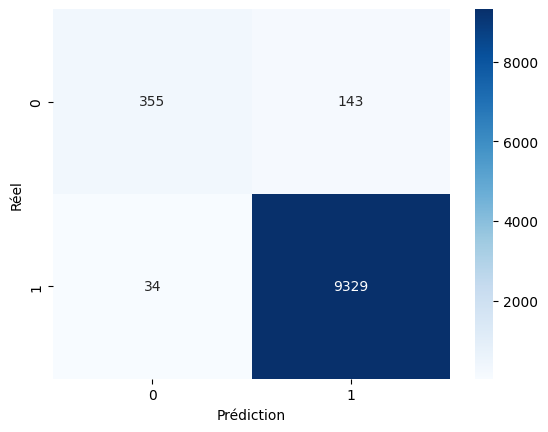

In [19]:
def heat_cm(y_test, y_pred): 
    cm = confusion_matrix(y_test,y_pred)

    sns.heatmap(cm, annot=True,fmt="d", cmap="Blues")
    plt.xlabel("Prédiction")
    plt.ylabel("Réel")
    plt.show() 

import seaborn as sns
heat_cm(y_test, y_pred_final)

                     Feature  Importance
0              Numero_grappe    0.198945
3      Score_richesse_menage    0.181020
4              Numero_menage    0.114955
6      ratio_enfants_adultes    0.098003
2              taille_menage    0.086094
5               Poids_menage    0.084988
10                       Age    0.061360
9                     Region    0.026933
8            Niveau_edu_chef    0.025320
12           Niveau_edu_pere    0.014007
13       Milieu_urbain_rural    0.008985
7   Quintile_richesse_menage    0.006568


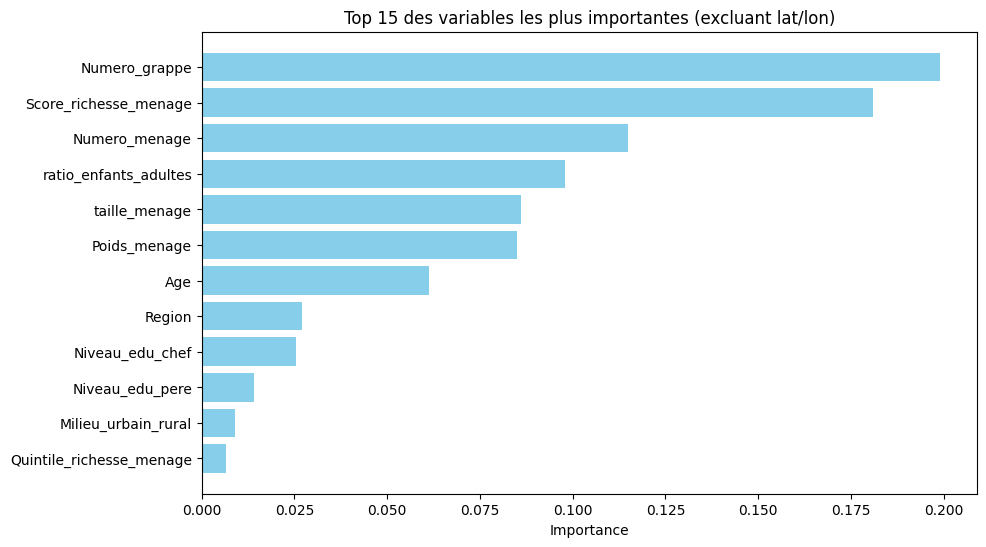

In [ ]:
if hasattr(rfc_selected, 'named_steps'):
    rf = rfc_selected.named_steps['clf']
else:
    rf = rfc_selected


features = X_test_selected.columns


importances = rf.feature_importances_


fi = pd.DataFrame({"Feature": features, "Importance": importances})
fi = fi[~fi["Feature"].isin(["lat", "lon"])]  
fi = fi.sort_values("Importance", ascending=False)


print(fi.head(15))


plt.figure(figsize=(10,6))
plt.barh(fi["Feature"].head(15)[::-1], fi["Importance"].head(15)[::-1], color="skyblue")
plt.xlabel("Importance")
plt.title("Top 15 des variables les plus importantes (excluant lat/lon)")
plt.show()